In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import workhorse as wh
import sentinnel_tools as st

# IMPORT AND FLAG DATA

In [7]:
# Take RDI textfile and convert to xarray dataset
#adcp1 = st.WinADCP_to_dataset('ADCP/ADCP01_all.txt')
#adcp2 = st.WinADCP_to_dataset('ADCP/ADCP02_all.txt')

# Conduct quality assurance tests and flag data
#adcp1 = st.adcp_qc(adcp1)
#adcp2 = st.adcp_qc(adcp2)

# Export to netcdf for future use
adcp1.to_netcdf('ADCP/adcp1.nc')
adcp2.to_netcdf('ADCP/adcp2.nc')

In [4]:
adcp1

<xarray.Dataset>
Dimensions:         (BinDist: 47, bin: 47, time: 34834)
Coordinates:
    BinDist         (bin) float64 0.81 1.06 1.31 1.56 ... 11.81 12.06 12.31
  * time            (time) datetime64[ns] 2022-07-21T10:30:00 ... 2022-08-14T...
Dimensions without coordinates: bin
Data variables:
    Pitch           (time) float64 25.4 25.4 25.39 25.4 ... -26.51 -26.51 -26.51
    Roll            (time) float64 26.22 26.22 26.22 26.22 ... 25.22 25.21 25.22
    Heading         (time) float64 193.2 193.2 193.3 193.2 ... 3.17 3.96 4.0
    Temperature     (time) float64 22.17 22.17 22.17 22.17 ... 25.16 25.12 25.09
    Depth           (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Battery         (time) int64 180 180 180 180 180 181 ... 142 142 142 141 142
    East            (BinDist, time) float64 nan nan nan nan ... nan nan nan nan
    North           (BinDist, time) float64 nan nan nan nan ... nan nan nan nan
    Vertical        (BinDist, time) float64 nan nan nan nan ... nan nan nan nan
    Magnitude       (BinDist, time) float64 nan nan nan nan ... nan nan nan nan
    Direction       (BinDist, time) float64 nan nan nan nan ... nan nan nan nan
    Error_velocity  (BinDist, time) float64 nan nan nan nan ... nan nan nan nan
    Correlation     (BinDist, time) int64 41 40 40 41 40 40 41 ... 0 0 0 0 0 0
    PG1             (BinDist, time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    PG4             (BinDist, time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    EA1             (BinDist, time) int64 43 43 43 43 44 43 ... 42 42 42 42 42
    EA2             (BinDist, time) int64 47 47 47 47 47 47 ... 47 47 47 46 46
    EA3             (BinDist, time) int64 111 111 111 111 112 ... 45 46 45 45 45
    EA4             (BinDist, time) int64 49 49 49 49 48 49 ... 46 46 46 46 46
    Flag            (BinDist, time) float64 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
Attributes:
    description:          Velocity in beam coordinates
    PingsPerEns:          70
    TimePerPing:          00:00.85
    First Ensemble Date:  22/07/21
    First Ensemble Time:  10:30:00.00
    Ensemble Interval:    60.0
    1st Bin Range:        0.81
    Bin Size:             0.25
    RDI binary file:      C:\Users\tconnolly\Desktop\LG_SWC_Depl\ADCP\SWC0100...
    Instrument:           Broadband 1228.8 kHz

# Plotting

<ipython-input-4-63ea2cca8a4a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.East,norm=norm)


(array([19198., 19202., 19205., 19209., 19213., 19217.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

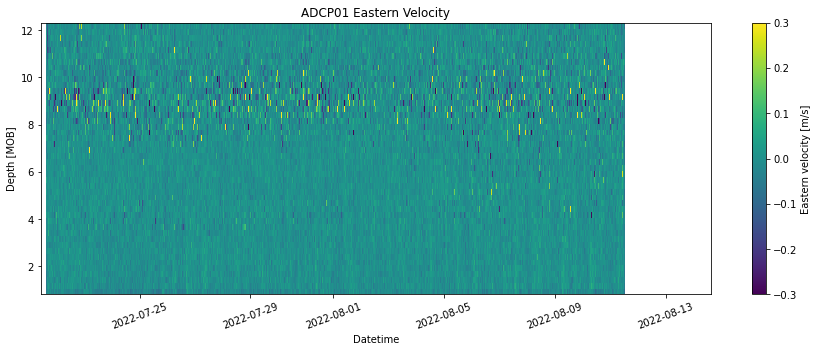

In [4]:
# Across shore colorplot
plt.figure(figsize = (15,5))
minvel = -.3 # Limits for the colorbars used on the adcp colorplots
maxvel = .3
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP01 Eastern Velocity')
plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.East,norm=norm)
plt.colorbar(label='Eastern velocity [m/s]')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

<ipython-input-5-b7e8ed66cd70>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.Flag,norm=norm)


(array([19198., 19202., 19205., 19209., 19213., 19217.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

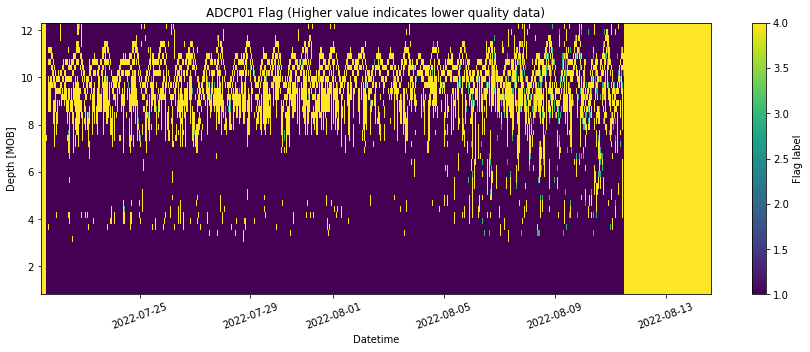

In [5]:
# Across shore colorplot
plt.figure(figsize = (15,5))
norm = matplotlib.colors.Normalize()
#minvel = 3 # Limits for the colorbars used on the adcp colorplots
#maxvel = 46
#norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP01 Flag (Higher value indicates lower quality data)')
plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.Flag,norm=norm)
plt.colorbar(label='Flag label')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

<ipython-input-151-77aed14c5c3c>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.East,norm=norm)


(array([19228., 19229., 19230., 19231., 19232., 19233., 19234.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

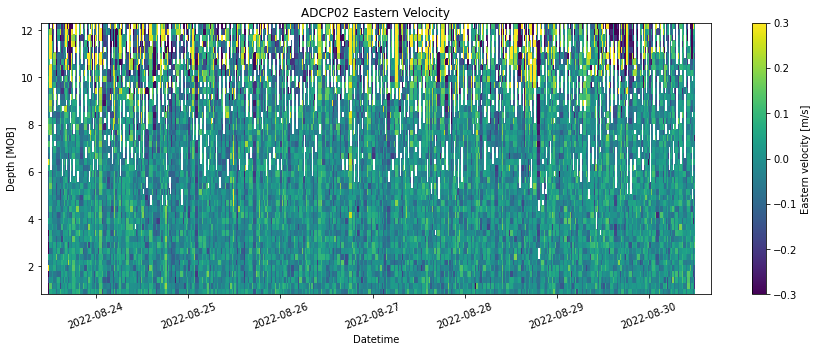

In [151]:
# Across shore colorplot
plt.figure(figsize = (15,5))
minvel = -.3 # Limits for the colorbars used on the adcp colorplots
maxvel = .3
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP02 Eastern Velocity')
plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.East,norm=norm)
plt.colorbar(label='Eastern velocity [m/s]')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

<ipython-input-6-24eba4ca83ca>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.Flag,norm=norm)


(array([19228., 19229., 19230., 19231., 19232., 19233., 19234.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

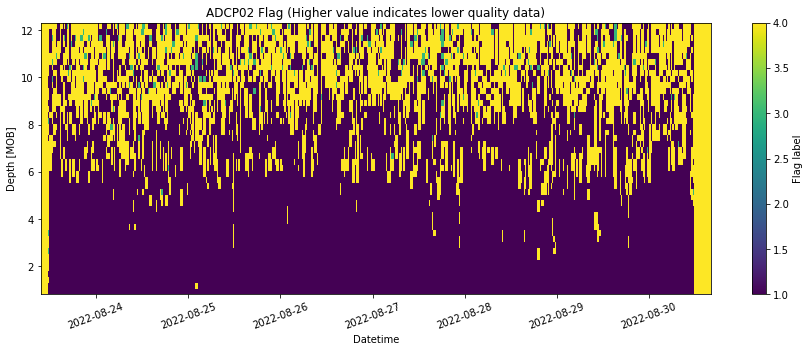

In [6]:
# Across shore colorplot
plt.figure(figsize = (15,5))
norm = matplotlib.colors.Normalize()
#minvel = 3 # Limits for the colorbars used on the adcp colorplots
#maxvel = 46
#norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP02 Flag (Higher value indicates lower quality data)')
plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.Flag,norm=norm)
plt.colorbar(label='Flag label')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

# BEAM COORDINATES

In [ ]:
# Import the beam coordinate csv's
b1 = pd.read_csv('ADCP/SWC2_000_1_export.csv')
b2 = pd.read_csv('ADCP/SWC2_000_2_export.csv')
b3 = pd.read_csv('ADCP/SWC2_000_3_export.csv')
b4 = pd.read_csv('ADCP/SWC2_000_4_export.csv')

In [ ]:
# Combine the csv's in chronological order
#data = b1.append(b2)
#data = data.append(b3)
#data = data.append(b4)
#data = data.reset_index(drop=True)
#data = data.drop(columns=['index'])
#data.to_csv('ADCP/beam_data.csv', index=False)
data = pd.read_csv('ADCP/beam_data.csv')

In [ ]:
vel = data.filter(like='V')

In [ ]:
vel_B1 = vel.filter(like='B1')
vel_B2 = vel.filter(like='B2')
vel_B3 = vel.filter(like='B3')
vel_B4 = vel.filter(like='B4')

In [ ]:
time = pd.to_datetime(data.iloc[:,1])
dcell = range(1,48,1)

In [ ]:
B1_arr = vel_B1.to_numpy()
B2_arr = vel_B2.to_numpy()
B3_arr = vel_B3.to_numpy()
B4_arr = vel_B4.to_numpy()

In [ ]:
# create coords
rows = range(1,48,1) 
cols = time

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        B1=(["time", "dcell"], B1_arr),
        B2=(["time", "dcell"], B2_arr),
        B3=(["time", "dcell"], B3_arr),
        B4=(["time", "dcell"], B4_arr)
    ),
    coords=dict(
        dcell=(["dcell"], rows),
        time=(["time"], cols),
    ),
    attrs=dict(description="Velocity in beam coordinates"),
)

In [ ]:
ds['B1'].attrs['units'] = 'mm/s'
ds['B2'].attrs['units'] = 'mm/s'
ds['B3'].attrs['units'] = 'mm/s'
ds['B4'].attrs['units'] = 'mm/s'

In [ ]:
ds